# Expression of Crow data

This notebook tests the hypothesis that the RNA-seq generic genes are those that are not well captured on microarray technology. [Zhao et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3894192/) found that one possible reason for differences in differentially expressed genes detected on different platforms is due to how genes are captured. RNA-Seq is more likely to detect the changes at two different conditions for genes with very low expression or very high expression compared to arrays.

This data was generated by running `download_Crow_data.R` script that downloads expression data from https://github.com/PavlidisLab/gemmaAPI.R

In [1]:
%load_ext autoreload
%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import ranking

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)
local_dir = params["local_dir"]
dataset_name = params["dataset_name"]
project_id = params["project_id"]
col_to_rank_genes = params["rank_genes_by"]
mapped_compendium_filename = params["mapped_compendium_filename"]

if_single_experiment = False

In [3]:
# Read in recount2 expression compendium
recount2_expression = pd.read_csv(
    mapped_compendium_filename, sep="\t", index_col=0, header=0
).T

## Format Crow expression data

* Include only genes that were used in our original analysis

In [4]:
# Read in Crow expression data
crow_expression_filename = os.path.join(local_dir, "Crow_expression_data_union.tsv")
crow_expression_data = pd.read_csv(
    crow_expression_filename, sep="\t", index_col=0, header=0
).T

In [5]:
crow_expression_data.shape

(14487, 32476)

In [6]:
crow_expression_data.head()

,L_IB38___BioAssayId=72907Name=050705MJA_U133_2.0_IB08.CEL,L_IB40___BioAssayId=72909Name=050705MJA_U133_2.0_IB10.CEL,L_IB41___BioAssayId=72910Name=050705MJA_U133_2.0_IB11.CEL,L_IB33___BioAssayId=72902Name=050705MJA_U133_2.0_IB03.CEL,L_IB36___BioAssayId=72905Name=050705MJA_U133_2.0_IB06.CEL,L_IB59___BioAssayId=72912Name=051223MJA_U133_2.0_IB59.CEL,L_IB60___BioAssayId=72913Name=051223MJA_U133_2.0_IB60.CEL,L_IB17___BioAssayId=72886Name=050511MJA_U133_2.0_IB17.CEL,L_IB20___BioAssayId=72889Name=050511MJA_U133_2.0_IB20.CEL,L_IB21___BioAssayId=72890Name=050511MJA_U133_2.0_IB21.CEL,...,GSE9988_Biomat_20___BioAssayId=88405Name=Anti.Trem1/LPS2hrsDonor10,GSE9988_Biomat_4___BioAssayId=88406Name=Anti.Trem1/LPS2hrsDonor3,GSE9988_Biomat_14___BioAssayId=88409Name=Anti.Trem1/LPS2hrsDonor5,GSE9988_Biomat_16___BioAssayId=88411Name=Anti.Trem1/LPS2hrsDonor9,GSE9988_Biomat_15___BioAssayId=88410Name=Anti.Trem1/LPS2hrsDonor7,GSE9988_Biomat_12___BioAssayId=88404Name=Anti.Trem1/LPS2hrsDonor2,GSE9988_Biomat_18___BioAssayId=88412Name=Anti.Trem1/LPS2hrsDonor4,GSE9988_Biomat_13___BioAssayId=88408Name=Anti.Trem1/LPS2hrsDonor11,GSE9988_Biomat_19___BioAssayId=88407Name=Anti.Trem1/LPS2hrsDonor6,GSE9988_Biomat_17___BioAssayId=88403Name=Anti.Trem1/LPS2hrsDonor1
HSPA6|HSPA7,8.96564,769.30450,23.69639,10.37628,48.51214,NaN,NaN,5.96790,8.36691,26.94385,...,7.119289,7.844919,7.152115,7.616878,6.273708,6.633022,7.270144,7.210642,6.469821,6.785819
UBA7,83.32761,61.90878,93.37774,56.58948,41.29277,27.79027,39.37290,30.72503,34.30363,21.10759,...,6.630704,6.887228,6.765646,6.751855,6.893142,6.932573,6.814365,6.721045,6.405350,6.925346
ESRRA,48.94783,119.33116,80.67838,64.83450,76.53021,NaN,NaN,90.35551,56.30252,23.17538,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CYP2A7|CYP2A6,6.05333,17.42643,27.73698,14.86978,15.66673,31.42781,24.67036,31.22093,35.16069,53.08181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAM32,17.74886,11.58205,18.56551,8.71849,5.35315,NaN,NaN,8.44734,11.41885,14.21983,...,2.853339,2.842427,2.890531,3.022254,3.012579,2.995602,2.880937,3.013476,2.976160,2.717715


In [7]:
# Load gene_summary_filename
gene_summary_filename = os.path.join(
    base_dir, dataset_name, f"generic_gene_summary_{project_id}.tsv"
)

summary_gene_ranks = pd.read_csv(gene_summary_filename, sep="\t", index_col=0, header=0)

In [8]:
summary_gene_ranks.head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Percentile (simulated),Percent DE (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.950328e-13,17569.0,10.694106,10.694106,0.002644,15704.0,88.447674,0.545455,2.071919,1.709103,22,5.044860
PRAME,PRAME,2.959784e-15,17568.0,8.664909,8.664909,0.020150,13854.0,78.027487,0.545455,2.219811,2.247804,22,2.867286
SLCO1B3,SLCO1B3,5.292942e-04,17567.0,8.325392,8.325392,0.000205,16755.0,94.367466,0.727273,2.723605,1.671155,22,3.352046
KCNC2,KCNC2,1.984004e-10,17566.0,8.230803,8.230803,0.078106,15568.0,87.681649,0.409091,2.091522,1.844182,22,3.328999
HOTAIR,HOTAIR,3.115241e-10,17565.0,8.228378,8.228378,0.000887,17311.0,97.499155,0.600000,3.252615,2.453550,20,2.027985


In [9]:
# Subset genes
our_gene_ids = list(summary_gene_ranks.index)
crow_gene_ids = list(crow_expression_data.index)

shared_gene_ids = set(crow_gene_ids).intersection(our_gene_ids)

expression_data = crow_expression_data.loc[shared_gene_ids]

In [10]:
print(expression_data.shape)
expression_data.head()

(11176, 32476)


,L_IB38___BioAssayId=72907Name=050705MJA_U133_2.0_IB08.CEL,L_IB40___BioAssayId=72909Name=050705MJA_U133_2.0_IB10.CEL,L_IB41___BioAssayId=72910Name=050705MJA_U133_2.0_IB11.CEL,L_IB33___BioAssayId=72902Name=050705MJA_U133_2.0_IB03.CEL,L_IB36___BioAssayId=72905Name=050705MJA_U133_2.0_IB06.CEL,L_IB59___BioAssayId=72912Name=051223MJA_U133_2.0_IB59.CEL,L_IB60___BioAssayId=72913Name=051223MJA_U133_2.0_IB60.CEL,L_IB17___BioAssayId=72886Name=050511MJA_U133_2.0_IB17.CEL,L_IB20___BioAssayId=72889Name=050511MJA_U133_2.0_IB20.CEL,L_IB21___BioAssayId=72890Name=050511MJA_U133_2.0_IB21.CEL,...,GSE9988_Biomat_20___BioAssayId=88405Name=Anti.Trem1/LPS2hrsDonor10,GSE9988_Biomat_4___BioAssayId=88406Name=Anti.Trem1/LPS2hrsDonor3,GSE9988_Biomat_14___BioAssayId=88409Name=Anti.Trem1/LPS2hrsDonor5,GSE9988_Biomat_16___BioAssayId=88411Name=Anti.Trem1/LPS2hrsDonor9,GSE9988_Biomat_15___BioAssayId=88410Name=Anti.Trem1/LPS2hrsDonor7,GSE9988_Biomat_12___BioAssayId=88404Name=Anti.Trem1/LPS2hrsDonor2,GSE9988_Biomat_18___BioAssayId=88412Name=Anti.Trem1/LPS2hrsDonor4,GSE9988_Biomat_13___BioAssayId=88408Name=Anti.Trem1/LPS2hrsDonor11,GSE9988_Biomat_19___BioAssayId=88407Name=Anti.Trem1/LPS2hrsDonor6,GSE9988_Biomat_17___BioAssayId=88403Name=Anti.Trem1/LPS2hrsDonor1
SNRK,324.20233,279.80804,392.32611,429.15829,201.04692,160.43004,293.39682,310.43698,471.02945,371.36218,...,9.035903,8.721971,8.435104,8.618270,9.203961,8.904986,8.756155,8.739322,8.389485,8.688545
SLC13A5,52.08654,85.66241,12.90283,38.03586,24.09035,NaN,34.99598,27.13274,36.05957,35.23805,...,4.605515,4.817713,5.064029,4.923493,4.667952,5.088648,4.813585,4.410202,4.642973,4.697124
ZNF577,36.41727,11.92280,66.29520,79.98004,50.31828,83.89149,60.71093,69.20666,221.24319,121.89088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COX6B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.454555,5.736751,5.410063,5.522444,5.645866,5.355902,5.648381,5.524881,5.142501,5.255222
GLRA3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## (optional) Select gene subset of samples

Select samples from a specific experiment to examine local gene expression behavior within a single experiment (local) in addition to across all samples (global)

We would actually like to do this for crow data but, we do not have metadata mapping experiment ids to sample ids. So this analysis option is only available for recount2 for now

In [11]:
recount2_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "recount2_metadata.tsv"
)

In [12]:
# Function scraped from ponyo since we're already using a different version of ponyo in this repo
def get_sample_ids_random_experiment(
    metadata_filename, delimiter, experiment_colname, sample_id_colname, rn_seed
):
    """
    Returns sample ids (found in gene expression df) associated with
    a given list of experiment ids (found in the metadata)

    Arguments
    ----------
    metadata_filename: str
        Metadata file path. An example metadata file can be found
        here: https://github.com/greenelab/ponyo/blob/master/human_tests/data/metadata/recount2_metadata.tsv

    delimiter: str
        Delimiter for metadata file

    experiment_colname: str
        Column header that contains the experiment ids

    sample_id_colname: str
        Column header that contains sample id that maps expression data
        and metadata

    """
    random.seed(rn_seed)

    # Read in metadata
    metadata = pd.read_csv(metadata_filename, header=0, sep=delimiter, index_col=None)

    # Set index column to experiment id column
    metadata.set_index(experiment_colname, inplace=True)

    # Select random experiment
    rn_experiment_id = random.choice(list(np.unique(metadata.index)))

    # Select samples associated with experiment id
    selected_metadata = metadata.loc[rn_experiment_id]
    sample_ids = list(selected_metadata[sample_id_colname])

    return sample_ids

In [13]:
if if_single_experiment:
    # Get sample ids for random experiment
    recount2_sample_ids = get_sample_ids_random_experiment(
        recount2_metadata_filename, "\t", "project", "run", 1
    )

    # Subset expression data
    recount2_expression = recount2_expression.loc[recount2_sample_ids]

## Get uncorrelated genes

r = 0.1851682008343338
p = 3.609310754973001e-132
ci_low = 0.17054283653055924
ci_high = 0.1993301766257059


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


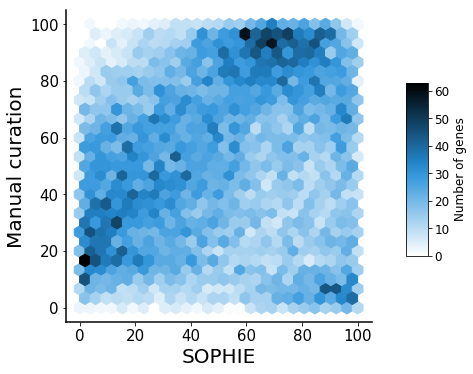

In [14]:
# Get generic genes identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]
ref_gene_col = params["reference_gene_name_col"]
ref_rank_col = params["reference_rank_col"]

figure_filename = f"gene_ranking_{col_to_rank_genes}_tmp.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks,
    DE_prior_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename,
)

In [15]:
shared_ranking.head()

,Percentile (simulated),DE_Prior_Rank,Gene_Name
Gene_Order,,,
10295,32.477188,46.298711,SNRK
8869,92.604483,53.729981,SLC13A5
10377,50.326687,45.865721,ZNF577
17352,27.819083,9.570139,IKBKG
7614,58.015095,60.284835,AIMP1


In [16]:
# Get uncorrelated gene ids
uncorrelated_ranking = shared_ranking[
    (shared_ranking["Percentile (simulated)"] > 80)
    & (shared_ranking["DE_Prior_Rank"] < 20)
]

uncorrelated_genes = uncorrelated_ranking["Gene_Name"]
print(len(uncorrelated_genes))

791


In [17]:
# Get correlated gene ids
correlated_ranking = shared_ranking[
    (shared_ranking["Percentile (simulated)"] > 80)
    & (shared_ranking["DE_Prior_Rank"] > 80)
]

correlated_genes = correlated_ranking["Gene_Name"]
print(len(correlated_genes))

900


In [18]:
# Save uncorrelated genes
uncorrelated_genes.to_csv("uncorrelated_genes.tsv", sep="\t")

## Plot average expression

In [19]:
# Get average expression of SOPHIE trained recount2 dataset
recount2_expression_mean = recount2_expression.mean(axis=1)

In [20]:
recount2_expression_mean.head()

A1BG         396.234336
A1BG-AS1     209.777608
A1CF         193.675354
A2M         5685.892147
A2M-AS1      177.060462
dtype: float64

In [21]:
# Get average expression of Crow dataset
crow_expression_mean = crow_expression_data.mean(axis=1)

In [22]:
crow_expression_mean.head()

HSPA6|HSPA7      18.885951
UBA7             29.220246
ESRRA            49.057550
CYP2A7|CYP2A6    17.760294
ADAM32            7.191467
dtype: float64

In [23]:
# Check that we selecting the correct genes
uncorrelated_genes = list(uncorrelated_genes.values)
uncorrelated_genes[0:5]

['APOL5', 'GPR25', 'OR6B1', 'AIPL1', 'CCDC105']

In [24]:
recount2_expression_mean[uncorrelated_genes].head()

APOL5       3.302230
GPR25       7.784335
OR6B1       0.496647
AIPL1      28.671386
CCDC105     0.798896
dtype: float64

In [25]:
crow_expression_mean.reindex(uncorrelated_genes).head()

APOL5       6.375579
GPR25      10.431437
OR6B1       5.805657
AIPL1      19.817377
CCDC105    10.632817
dtype: float64

In [26]:
recount2_expression_mean.head()

A1BG         396.234336
A1BG-AS1     209.777608
A1CF         193.675354
A2M         5685.892147
A2M-AS1      177.060462
dtype: float64

In [27]:
# Format df for plotting
recount2_expression_mean_toplot = pd.DataFrame(
    data={
        "All genes": np.log10(recount2_expression_mean),
        "Common in RNA-seq and array": np.log10(
            recount2_expression_mean[correlated_genes]
        ),
        "Common in only RNA-seq": np.log10(
            recount2_expression_mean[uncorrelated_genes]
        ),
    }
)


recount2_expression_mean_toplot.head()

,All genes,Common in RNA-seq and array,Common in only RNA-seq
A1BG,2.597952,NaN,NaN
A1BG-AS1,2.321759,NaN,NaN
A1CF,2.287074,NaN,NaN
A2M,3.754799,NaN,NaN
A2M-AS1,2.248122,NaN,NaN


Number of uncorrelated gene data available: 791


Text(0.5, 0, 'Log$_{10}$ (average expression)')

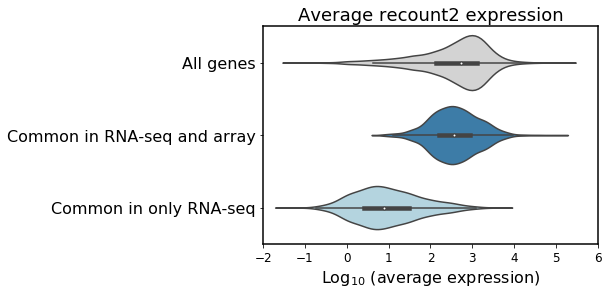

In [28]:
# Violin plot of average recount2 expression highlighing uncorrelated genes
print(
    f"Number of uncorrelated gene data available: {len(recount2_expression_mean[uncorrelated_genes])}"
)
f = sns.violinplot(
    data=recount2_expression_mean_toplot,
    palette=["lightgrey", "#2c7fb8", "#add8e6"],
    orient="h",
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.xlim(-2, 6)

# Make axis thicker
for _, s in f.spines.items():
    s.set_linewidth(1.5)

f.set_title("Average recount2 expression", fontsize=18)
f.set_xlabel(r"Log$_{10}$ (average expression)", fontsize=16)

In [29]:
f.get_figure().savefig(
    "recount2_expression_dist_gene_groups_highlight.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

In [30]:
# Format df for plotting
crow_expression_mean_toplot = pd.DataFrame(
    data={
        "All genes": np.log10(crow_expression_mean),
        "Common in RNA-seq and array": np.log10(crow_expression_mean[correlated_genes]),
        "Common only in RNA-seq": np.log10(crow_expression_mean[uncorrelated_genes]),
    }
)


crow_expression_mean_toplot.head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,All genes,Common in RNA-seq and array,Common only in RNA-seq
A1BG,1.082719,NaN,NaN
A1BG-AS1,0.945520,NaN,NaN
A1CF,0.593314,NaN,NaN
A2M,2.166631,NaN,NaN
A2M-AS1,1.238627,NaN,NaN


Number of uncorrelated gene data available: 791


Text(0.5, 0, 'Log$_{10}$ (average expression)')

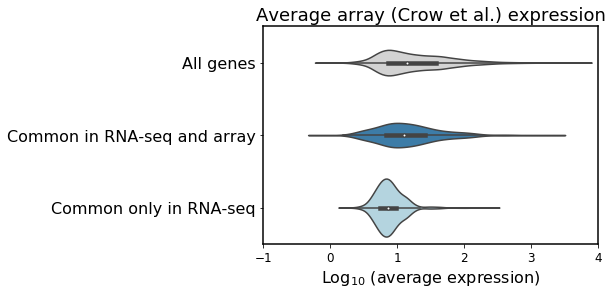

In [31]:
# Violin plot of average array expression highlighing uncorrelated genes
print(
    f"Number of uncorrelated gene data available: {len(crow_expression_mean.reindex(uncorrelated_genes))}"
)
g = sns.violinplot(
    data=crow_expression_mean_toplot,
    palette=["lightgrey", "#2c7fb8", "#add8e6"],
    orient="h",
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
plt.xlim(-1, 4)

# Make axis thicker
for _, s in g.spines.items():
    s.set_linewidth(1.5)

g.set_title("Average array (Crow et al.) expression", fontsize=18)
g.set_xlabel(r"Log$_{10}$ (average expression)", fontsize=16)

In [32]:
g.get_figure().savefig(
    "array_expression_dist_gene_groups_highlight.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* Our hypothesis is that these RNA-seq generic genes are those that are not well captured on microarray technology.
* Based on the distribution of the array data, it looks like these genes are fairly lowly expressed, but based on the density of the violin plot there appear to be many genes that have a similar range of expression. So these RNA-seq generic genes are as well captured as RNA-seq/array generic genes.
* This hypothesis does not seem to hold

**Other thoughts:**

Looking to characterize _who_ these RNA-seq generic genes are, we used https://academic.oup.com/nar/article/48/D1/D174/5588346 to lookup the RNA-seq generic genes to determine if they have 3' end processing (i.e. polyadenylation sites)

Manually looking up individual genes (since there doesn't seem to be a way to do this in batch), we found that most genes have at least one polyadenylated site.